In [1]:
import requests
import pandas as pd
import time
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
START, END = 2020, 2024            
TEMPORAL = "daily"                  

PARAMS = [
    # precipitation & humidity
    "PRECTOTCORR","RH2M","QV2M",
    # temperature (2m)
    "T2M","T2M_MAX","T2M_MIN","T2M_RANGE",
    # wind (2m,10m), direction (10m)
    "WS2M","WS10M","WD10M",
    # radiation (shortwave, all-sky, clear-sky)
    "ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN",
    # pressure
    "PS",
    # soil moisture 
    "GWETTOP","GWETROOT"
]
# region France (INSEE, name, lat, lon)
Regions = [
    ("83", "Auvergne-Rhône-Alpes", 45.2968119, 4.6604809),
    ("27", "Bourgogne-Franche-Comté", 47.118711, 4.9691044),
    ("53", "Bretagne", 48.2640845, -2.9202408),
    ("24", "Centre-Val de Loire", 47.5490251, 1.7324062),
    ("44", "Grand-Est", 48.4845157, 6.113035),
    ("32", "Hauts-de-France", 50.1024606, 2.7247515),
    ("11", "Ile-de-France", 48.6443057, 2.7537863),
    ("28", "Normandie", 49.0677708, 0.3138532),
    ("75", "Nouvelle-Aquitaine", 45.4039367, 0.3756199),
    ("76", "Occitanie", 43.6487851, 2.3435684),
    ("52", "Pays-de-la-Loire", 47.6594864, -0.8186143),
    ("93", "PACA", 44.0580563, 6.0638506),
]


In [3]:
REGION_POINTS = {
    "Auvergne-Rhône-Alpes": [
        ("center", 45.7500, 4.8500),   # Lyon 
        ("north",  46.2050, 5.2280),   # Bourg-en-Bresse 
        ("south",  44.9330, 4.8920),   # Valence 
        ("east",   45.8990, 6.1290),   # Annecy 
        ("west",   45.7830, 3.0830),   # Clermont-Ferrand 
    ],

    "Bourgogne-Franche-Comté": [
        ("center", 47.3220, 5.0410),   # Dijon 
        ("north",  47.7990, 3.5730),   # Auxerre 
        ("south",  46.3060, 4.8280),   # Mâcon 
        ("east",   47.2380, 6.0240),   # Besançon 
        ("west",   46.9890, 3.1590),   # Nevers 
    ],

    "Bretagne": [
        ("center", 48.1170, -1.6780),  # Rennes
        ("north",  48.5150, -2.7650),  # Saint-Brieuc
        ("south",  47.6580, -2.7600),  # Vannes 
        ("east",   48.3530, -1.1990),  # Fougères 
        ("west",   48.3900, -4.4860),  # Brest 
    ],

    "Centre-Val de Loire": [
        ("center", 47.9020, 1.9090),   # Orléans 
        ("north",  48.4470, 1.4890),   # Chartres 
        ("south",  46.8100, 1.6930),   # Châteauroux
        ("east",   47.5930, 1.3290),   # Blois 
        ("west",   47.3940, 0.6848),   # Tours 
    ],

    "Grand-Est": [
        ("center", 48.6930, 6.1830),   # Nancy 
        ("north",  49.7680, 4.7240),   # Charleville-Mézières 
        ("south",  47.7500, 7.3350),   # Mulhouse 
        ("east",   48.5730, 7.7520),   # Strasbourg 
        ("west",   49.2580, 4.0310),   # Reims 
    ],

    "Hauts-de-France": [
        ("center", 49.8940, 2.3000),   # Amiens 
        ("north",  51.0380, 2.3770),   # Dunkerque 
        ("south",  49.4300, 2.0830),   # Beauvais 
        ("east",   50.3570, 3.5240),   # Valenciennes 
        ("west",   50.7260, 1.6150),   # Boulogne-sur-Mer 
    ],

    "Ile-de-France": [
        ("center", 48.8566, 2.3522),   # Paris 
        ("north",  49.0360, 2.0630),   # Cergy 
        ("south",  48.6290, 2.4410),   # Évry-Courcouronnes 
        ("east",   48.9600, 2.8880),   # Meaux
        ("west",   48.8049, 2.1204),   # Versailles 
    ],

    "Normandie": [
        ("center", 49.1830, -0.3690),  # Caen 
        ("north",  49.9220, 1.0770),   # Dieppe 
        ("south",  48.4310, 0.0930),   # Alençon
        ("east",   49.0270, 1.1510),   # Évreux 
        ("west",   49.6390, -1.6210),  # Cherbourg-en-Cotentin 
    ],

    "Nouvelle-Aquitaine": [
        ("center", 45.6480, 0.1560),   # Angoulême 
        ("north",  46.5800, 0.3400),   # Poitiers 
        ("south",  43.2950, -0.3708),  # Pau 
        ("east",   45.8336, 1.2611),   # Limoges 
        ("west",   44.8378, -0.5792),  # Bordeaux 
    ],

    "Occitanie": [
        ("center", 43.6045, 1.4440),   # Toulouse 
        ("north",  44.3500, 2.5800),   # Rodez 
        ("south",  42.6880, 2.8940),   # Perpignan 
        ("east",   43.6108, 3.8767),   # Montpellier 
        ("west",   43.2330, 0.0830),   # Tarbes 
    ],

    "Pays-de-la-Loire": [
        ("center", 47.4780, -0.5630),  # Angers
        ("north",  48.0730, -0.7730),  # Laval 
        ("south",  46.6700, -1.4260),  # La Roche-sur-Yon 
        ("east",   48.0077, 0.1984),   # Le Mans
        ("west",   47.2184, -1.5536),  # Nantes 
    ],

    "PACA": [
        ("center", 43.5297, 5.4470),   # Aix-en-Provence 
        ("north",  44.5590, 6.0799),   # Gap 
        ("south",  43.1242, 5.9280),   # Toulon 
        ("east",   43.7102, 7.2620),   # Nice
        ("west",   43.9493, 4.8055),   # Avignon
    ],
}


In [4]:
def fetch_power(lat, lon, start_year, end_year, temporal="daily"):
    """
    Return a DataFrame with one row per date (daily or monthly
    No aggregation.
    """
    if temporal not in ("daily","monthly"):
        raise ValueError("temporal must be 'daily' or 'monthly'")

    url = (
        f"https://power.larc.nasa.gov/api/temporal/{temporal}/point"
        f"?parameters={','.join(PARAMS)}"
        f"&community=AG&longitude={lon}&latitude={lat}"
        f"&start={start_year}&end={end_year}&format=JSON"
    )
    r = requests.get(url, timeout=90)
    if not r.ok or "application/json" not in (r.headers.get("Content-Type","").lower()):
        raise RuntimeError(f"POWER error {r.status_code}: {r.text[:200]}")

    param = r.json().get("properties",{}).get("parameter",{})
    rows = []
    for var, series in param.items():
        for key, val in series.items():
            if temporal == "daily":   
                y, m, d = int(key[:4]), int(key[4:6]), int(key[6:8])
            else:                     
                y, m, d = int(key[:4]), int(key[4:]), 1
            rows.append({"year":y,"month":m,"day":d,"var":var,"value":float(val)})
    long = pd.DataFrame(rows).sort_values(["year","month","day"])
    wide = long.pivot(index=["year","month","day"], columns="var", values="value").reset_index()
    wide["date"] = pd.to_datetime(dict(year=wide.year, month=wide.month, day=wide.day))
    cols = ["date","year","month","day"] + [c for c in wide.columns if c not in ("date","year","month","day")]
    return wide[cols]

In [5]:
def fetch_region_weather_mean(region_name, start_year, end_year, temporal="daily"):
    """
    Fetch NASA POWER for several points in a region and
    return the daily mean weather per region.
    """
    if region_name not in REGION_POINTS:
        raise ValueError(f"Region '{region_name}' not in REGION_POINTS")

    dfs = []
    for label, lat, lon in REGION_POINTS[region_name]:
        df_pt = fetch_power(lat, lon, start_year, end_year, temporal=temporal)
        df_pt["subpoint"] = label
        df_pt["Regions"] = region_name   # same column name as your ele data
        dfs.append(df_pt)

    df_all = pd.concat(dfs, ignore_index=True)

    # weather columns
    meta_cols = ["date", "year", "month", "day", "subpoint", "Regions"]
    weather_cols = [c for c in df_all.columns if c not in meta_cols]

    # average over the 5 villes
    df_region = (
        df_all
        .groupby(["date", "year", "month", "day", "Regions"], as_index=False)[weather_cols]
        .mean()
    )
    return df_region

In [6]:
all_regions_weather = []
for insee, name, lat, lon in Regions:
    print("Fetching region:", name)
    df_reg = fetch_region_weather_mean(name, START, END, temporal=TEMPORAL)
    all_regions_weather.append(df_reg)
df_weather_regions = pd.concat(all_regions_weather, ignore_index=True)
df_weather_regions.rename(columns={"date": "Datetime"}, inplace=True)

Fetching region: Auvergne-Rhône-Alpes
Fetching region: Bourgogne-Franche-Comté
Fetching region: Bretagne
Fetching region: Centre-Val de Loire
Fetching region: Grand-Est
Fetching region: Hauts-de-France
Fetching region: Ile-de-France
Fetching region: Normandie
Fetching region: Nouvelle-Aquitaine
Fetching region: Occitanie
Fetching region: Pays-de-la-Loire
Fetching region: PACA


In [7]:
# load regions polygons
regions_url = "https://france-geojson.gregoiredavid.fr/repo/regions.geojson"
gdf_regions = gpd.read_file(regions_url)
gdf_regions.head()


,code,nom,geometry
0,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1..."
1,24,Centre-Val de Loire,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((6.94054 47.43337, 6.94168 47.4158, 6..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,..."
4,32,Hauts-de-France,"POLYGON ((4.14089 49.97876, 4.15398 49.97484, ..."


In [8]:

# Flatten to a DataFrame
rows = []
for reg, pts in REGION_POINTS.items():
    for label, lat, lon in pts:
        rows.append({"region_key": reg, "label": label, "lat": lat, "lon": lon})

df_pts = pd.DataFrame(rows)

# Turn into GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    df_pts,
    geometry=gpd.points_from_xy(df_pts["lon"], df_pts["lat"]),
    crs="EPSG:4326",
)


In [9]:
# Show name on the plot 
name_map = {
    "Auvergne-Rhône-Alpes": "Auvergne-Rhône-Alpes",
    "Bourgogne-Franche-Comté": "Bourgogne-Franche-Comté",
    "Bretagne": "Bretagne",
    "Centre-Val de Loire": "Centre-Val de Loire",
    "Grand-Est": "Grand Est",
    "Hauts-de-France": "Hauts-de-France",
    "Ile-de-France": "Île-de-France",
    "Normandie": "Normandie",
    "Nouvelle-Aquitaine": "Nouvelle-Aquitaine",
    "Occitanie": "Occitanie",
    "Pays-de-la-Loire": "Pays de la Loire",
    "PACA": "Provence-Alpes-Côte d'Azur",
}

gdf_regions = gdf_regions[gdf_regions["nom"].isin(name_map.values())].copy()
reverse_map = {v: k for k, v in name_map.items()}
gdf_regions["region_key"] = gdf_regions["nom"].map(reverse_map)


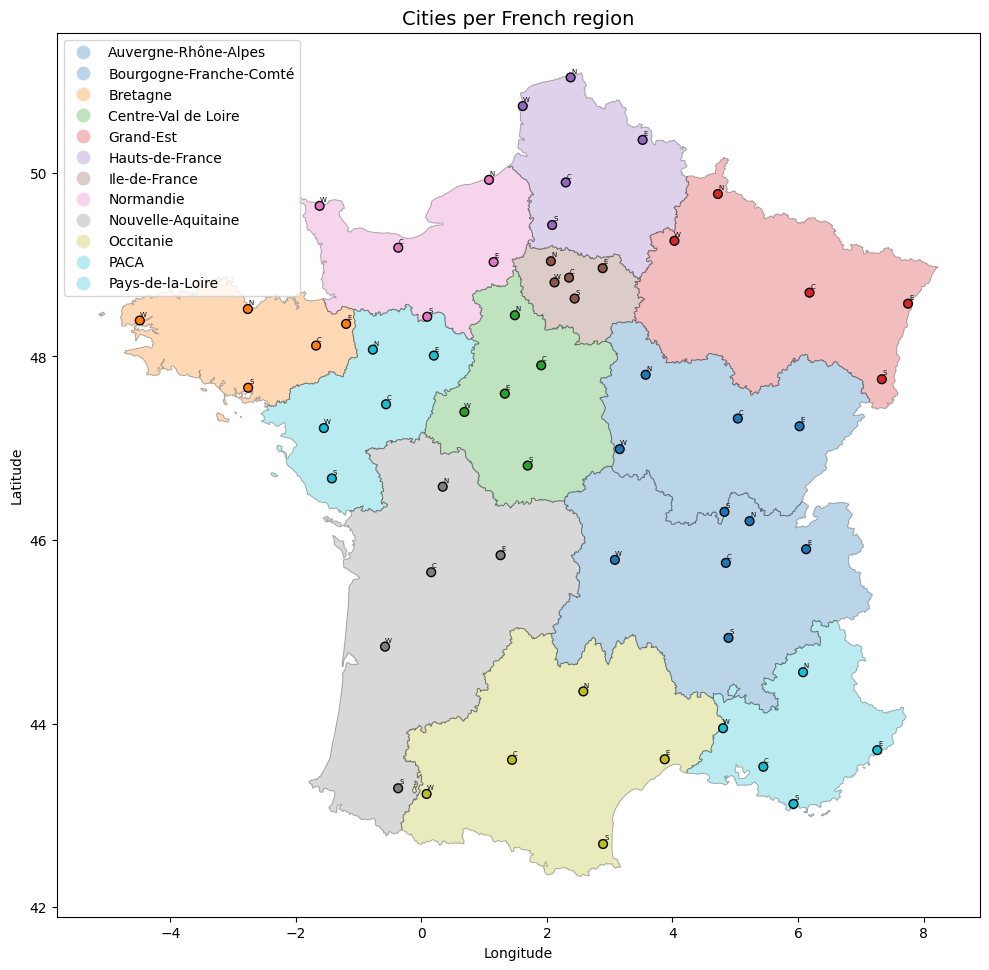

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot regions with a different color per region
gdf_regions.plot(
    column="region_key",
    categorical=True,
    legend=True,
    edgecolor="black",
    linewidth=0.7,
    alpha=0.3,
    ax=ax,
)

# Plot points and colors 
gdf_points.plot(
    ax=ax,
    column="region_key",
    categorical=True,
    markersize=40,
    edgecolor="black",
    legend=False,
)
# add label
for _, row in gdf_points.iterrows():
    ax.text(
        row.geometry.x + 0.05,
        row.geometry.y + 0.05,
        row["label"][0].upper(),  
        fontsize=5,
        ha="center",
    )
ax.set_title("Cities per French region", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


In [11]:
df_weather_regions.head()

var,Datetime,year,month,day,Regions,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,GWETROOT,GWETTOP,PRECTOTCORR,PS,QV2M,RH2M,T2M,T2M_MAX,T2M_MIN,T2M_RANGE,WD10M,WS10M,WS2M
0,2020-01-01,2020,1,1,Auvergne-Rhône-Alpes,5.494,6.860,0.768,0.778,0.062,97.706,3.690,87.752,0.940,4.552,-0.758,5.310,291.10,1.938,1.168
1,2020-01-02,2020,1,2,Auvergne-Rhône-Alpes,4.532,6.448,0.768,0.778,0.042,97.484,4.194,87.350,2.642,7.794,-0.600,8.394,175.38,3.454,2.140
2,2020-01-03,2020,1,3,Auvergne-Rhône-Alpes,3.846,6.454,0.766,0.778,0.318,97.456,4.872,89.086,4.570,8.598,1.944,6.654,196.00,2.976,1.748
3,2020-01-04,2020,1,4,Auvergne-Rhône-Alpes,4.684,7.002,0.766,0.778,0.346,97.844,4.846,94.106,3.732,7.036,-0.244,7.280,276.04,3.874,2.512
4,2020-01-05,2020,1,5,Auvergne-Rhône-Alpes,6.516,7.210,0.766,0.778,0.026,97.850,3.932,91.162,1.246,5.364,-1.542,6.906,236.76,3.654,2.338


In [12]:
df_weather_regions.head()

var,Datetime,year,month,day,Regions,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,GWETROOT,GWETTOP,PRECTOTCORR,PS,QV2M,RH2M,T2M,T2M_MAX,T2M_MIN,T2M_RANGE,WD10M,WS10M,WS2M
0,2020-01-01,2020,1,1,Auvergne-Rhône-Alpes,5.494,6.860,0.768,0.778,0.062,97.706,3.690,87.752,0.940,4.552,-0.758,5.310,291.10,1.938,1.168
1,2020-01-02,2020,1,2,Auvergne-Rhône-Alpes,4.532,6.448,0.768,0.778,0.042,97.484,4.194,87.350,2.642,7.794,-0.600,8.394,175.38,3.454,2.140
2,2020-01-03,2020,1,3,Auvergne-Rhône-Alpes,3.846,6.454,0.766,0.778,0.318,97.456,4.872,89.086,4.570,8.598,1.944,6.654,196.00,2.976,1.748
3,2020-01-04,2020,1,4,Auvergne-Rhône-Alpes,4.684,7.002,0.766,0.778,0.346,97.844,4.846,94.106,3.732,7.036,-0.244,7.280,276.04,3.874,2.512
4,2020-01-05,2020,1,5,Auvergne-Rhône-Alpes,6.516,7.210,0.766,0.778,0.026,97.850,3.932,91.162,1.246,5.364,-1.542,6.906,236.76,3.654,2.338


In [13]:
df_weather_regions.shape

(21924, 20)

<Axes: xlabel='var'>

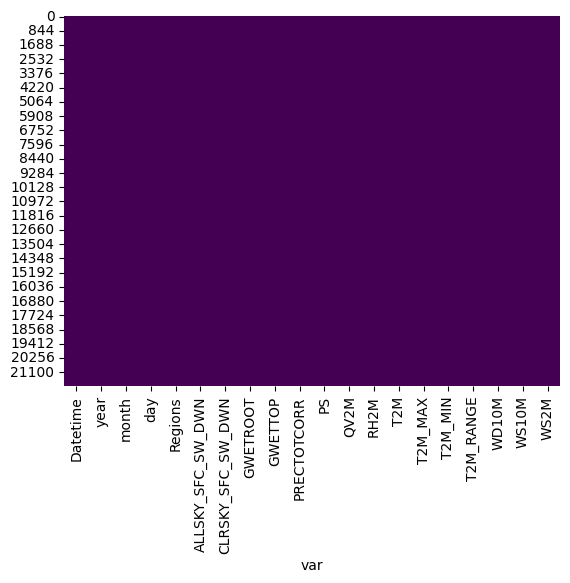

In [14]:
sns.heatmap(df_weather_regions.isnull(),cbar=False,cmap='viridis')

In [15]:
df_weather_regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21924 entries, 0 to 21923
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Datetime           21924 non-null  datetime64[ns]
 1   year               21924 non-null  int64         
 2   month              21924 non-null  int64         
 3   day                21924 non-null  int64         
 4   Regions            21924 non-null  object        
 5   ALLSKY_SFC_SW_DWN  21924 non-null  float64       
 6   CLRSKY_SFC_SW_DWN  21924 non-null  float64       
 7   GWETROOT           21924 non-null  float64       
 8   GWETTOP            21924 non-null  float64       
 9   PRECTOTCORR        21924 non-null  float64       
 10  PS                 21924 non-null  float64       
 11  QV2M               21924 non-null  float64       
 12  RH2M               21924 non-null  float64       
 13  T2M                21924 non-null  float64       
 14  T2M_MA

In [16]:
df_weather_regions.isnull().sum()

var
Datetime             0
year                 0
month                0
day                  0
Regions              0
ALLSKY_SFC_SW_DWN    0
CLRSKY_SFC_SW_DWN    0
GWETROOT             0
GWETTOP              0
PRECTOTCORR          0
PS                   0
QV2M                 0
RH2M                 0
T2M                  0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
WD10M                0
WS10M                0
WS2M                 0
dtype: int64

In [17]:
df_weather_regions.to_csv(f"Region_France_weather_{TEMPORAL}_{START}_{END}.csv", index=False)
